# Forecasting Stock Prices
**Data Analytics and Big Data Capstone Project 2018c-5 - Data Science with Python**

### 4. Finding Best Model - workspace

#### Table of Contents
    4.1 Moving Average
    4.2 Linear Regression
    4.3 k-Nearest Neighbors
    4.4 Auto ARIMA
    4.5 ARIMA    
    4.6 Prophet
    4.7 Long Short Term Memory (LSTM)
    4.8 LSTM Optimazed
    
**Note**. In this exercise we will use the following metrics.
    - MSE: Mean Squared Error
    - MAE: Mean absolute error
    - RMSE: Root Mean Square
    - MAPE: Mean Absolute Percentage Error

In [2]:
# Load libraries
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns; sns.set()
import tensorflow as tf
import time

from matplotlib.pyplot import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fastai.tabular import add_datepart
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from numpy.random import seed
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm_notebook
from datetime import date

# plot within notebook
%matplotlib inline

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
## load parameters

# set start and end date range
start_date = dt.datetime(2018, 1, 31)
end_date = dt.datetime(2020, 5, 30)

#### Input params ##################
train_size = 0.8               # proportion of dataset to be used as train set
valid_size = 0.2               # proportion of dataset to be used as valid set
train_rows = 0
valid_rows = 0

scaler = MinMaxScaler(feature_range=(0, 1))

# set figure size
rcParams['figure.figsize'] = 15, 8

In [4]:
# Load dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# load data
df_adj = pd.read_csv('.\\data\\eod.data-intc-decompose.lv2.csv')

In [20]:
# setting the index as date
#df_adj['date'] = pd.to_datetime(df_adj.date, format='%Y-%m-%d')
#df_adj.index = df_adj['date']
#df_adj.drop(['date'], axis=1, inplace=True)
#df_adj.sort_index(ascending=True, axis=0, inplace=True)
#df_adj.head(5)

### 4.1 Moving Average

In [22]:
# create empty dataset
#new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['Date', 'Close'])

In [23]:
# copy values to new structure
#for i in range(0, len(df_adj)):
#    new_data['Date'][i] = df_adj.index[i]
#    new_data['Close'][i] = df_adj.close[i]
#    
#new_data.head(5)

In [5]:
# set train and valid rows len
train_rows = math.trunc(len(df_adj) * train_size)
valid_rows = len(df_adj) - train_rows

# splitting into train and validation
train = df_adj[:train_rows]
valid = df_adj[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [6]:
# making predictions
preds = []
for i in range(0, valid.shape[0]):
    a = train['close'][len(train)-valid_rows+i].sum() + sum(preds)
    b = a/valid_rows
    preds.append(b)

In [7]:
# report performance
mse = mean_squared_error(valid['close'], preds)
print('MSE: '+str(mse))

mae = mean_absolute_error(valid['close'], preds)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid['close'], preds))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(preds - valid['close'])/np.abs(valid['close']))
print('MAPE: '+str(mape))

MSE: 16.042628339045766
MAE: 4.004316093899797
RMSE: 4.005324997930351
MAPE: 0.9849769712130486


The MAPE indicator around 98.70% implies that the model has an accuracy close to -1.3% to predict the observations of the data set. The RMSE 57.97% indicator shows that it is correct.

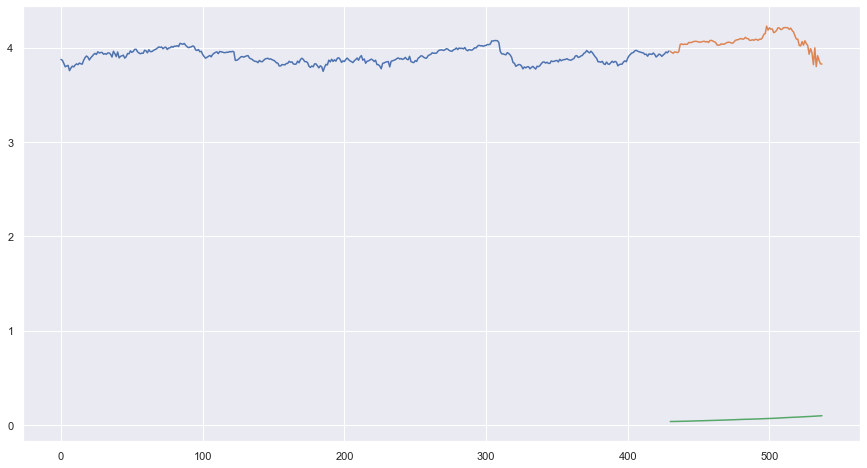

In [8]:
# copy predictions into valid data
valid['Predictions'] = 0
valid['Predictions'] = preds

# plot predict values
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Moving_Average_lv2.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Moving Average' is not an appropriate predictive technique for this data set.

### 4.2 Linear Regression

In [9]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

In [10]:
# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]
    
new_data.head(5)

date    close
0  2018-01-31  3.87411
1  2018-02-01  3.86388
2  2018-02-02   3.8319
3  2018-02-05  3.79594
4  2018-02-06  3.80466

In [11]:
# create features
add_datepart(new_data, 'date')

# remove atribute 'Elapsed', axis=1 means colummn
new_data.drop('Elapsed', axis=1, inplace=True)

new_data.head(5)

close  Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  \
0  3.87411  2018      1     5   31          2         31          True   
1  3.86388  2018      2     5    1          3         32         False   
2   3.8319  2018      2     5    2          4         33         False   
3  3.79594  2018      2     6    5          0         36         False   
4  3.80466  2018      2     6    6          1         37         False   

   Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
0           False           False             False        False   
1            True           False             False        False   
2           False           False             False        False   
3           False           False             False        False   
4           False           False             False        False   

   Is_year_start  
0          False  
1          False  
2          False  
3          False  
4          False

In [12]:
# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 13)

 Shape of validation set:
(108, 13)


In [13]:
# create train and valid dataset
x_train = train.drop('close', axis=1)
y_train = train['close']

x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

# implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# make predictions and find the rmse
preds = model.predict(x_valid)

In [15]:
# report performance
mse = mean_squared_error(y_valid, preds)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_valid, preds)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_valid, preds))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(preds - y_valid)/np.abs(y_valid))
print('MAPE: '+str(mape))

MSE: 0.04630732765984203
MAE: 0.20053575408177712
RMSE: 0.2151913745014935
MAPE: 0.04897653830551751


The MAPE indicator around 17.90% implies that the model has an accuracy close to 82.11% to predict the observations of the data set. The RMSE 11.67% indicates that it is correct and that we are approaching a better prediction model.

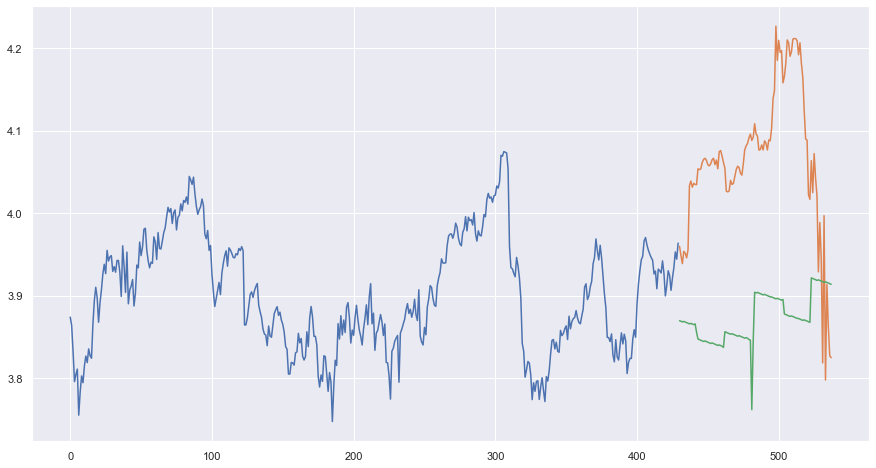

In [17]:
# add predictions to valid set
valid['Predictions'] = 0
valid['Predictions'] = preds

# add index value to train and valid set
valid.index = new_data[train_rows:].index
train.index = new_data[:train_rows].index

# plot
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Linear_Regression_lv2.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Linear Regression' is not an appropriate predictive technique for this data set.

### 4.3 k-Nearest Neighbours

In [18]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# create features
add_datepart(new_data, 'date')

# remove atribute 'Elapsed', axis=1 means colummn
new_data.drop('Elapsed', axis=1, inplace=True)

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 13)

 Shape of validation set:
(108, 13)


In [19]:
# create train and valid dataset
x_train = train.drop('close', axis=1)
y_train = train['close']

x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

In [20]:
# scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

x_train.head(5)

0         1         2         3     4         5    6    7    8    9   10  \
0  0.0  0.000000  0.078431  1.000000  0.50  0.079890  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.090909  0.078431  0.000000  0.75  0.082645  0.0  1.0  0.0  0.0  0.0   
2  0.0  0.090909  0.078431  0.033333  1.00  0.085399  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.090909  0.098039  0.133333  0.00  0.093664  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.090909  0.098039  0.166667  0.25  0.096419  0.0  0.0  0.0  0.0  0.0   

    11  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [21]:
x_valid.head(5)

0         1         2         3     4         5    6    7    8    9   10  \
0  0.0  0.818182  0.803922  0.500000  0.50  0.790634  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.818182  0.803922  0.533333  0.75  0.793388  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.818182  0.803922  0.566667  1.00  0.796143  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.818182  0.823529  0.666667  0.00  0.804408  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.818182  0.823529  0.700000  0.25  0.807163  0.0  0.0  0.0  0.0  0.0   

    11  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [22]:
# using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
#fit the model and make predictions
model.fit(x_train, y_train)
preds = model.predict(x_valid)

In [24]:
# report performance
mse = mean_squared_error(y_valid, preds)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_valid, preds)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_valid, preds))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(preds - y_valid)/np.abs(y_valid))
print('MAPE: '+str(mape))

MSE: 0.04012266947154585
MAE: 0.18986580257378916
RMSE: 0.20030643891684025
MAPE: 0.046497091142661776


The MAPE indicator around 17.20% implies that the model has an accuracy close to 82.80% to predict the observations of the data set. The RMSE 10.90% indicates that it is correct and that we are approaching a better prediction model.

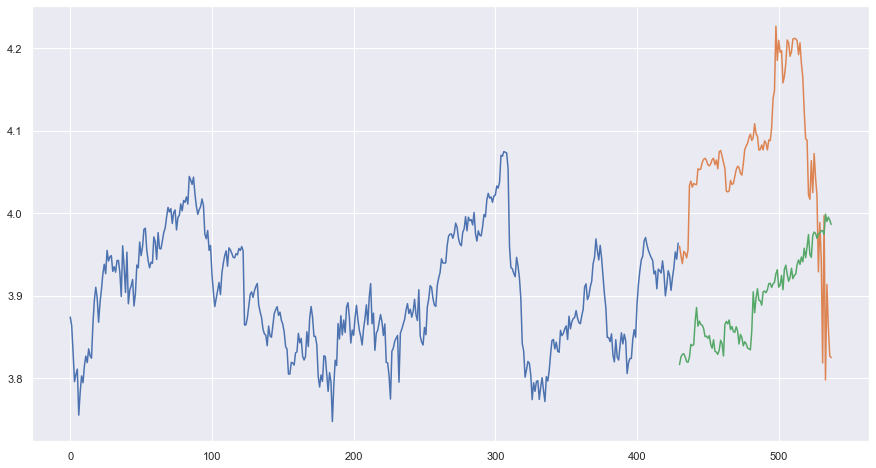

In [25]:
# copy pridictions to valid set
valid['Predictions'] = 0
valid['Predictions'] = preds

# plot
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_LNN_lv2.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'k-Nearest Neighbours' is not an appropriate predictive technique for this data set.

### 4.4 Auto ARIMA

In [26]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [27]:
# set sub dataset 
training = train['close']
validation = valid['close']

model = auto_arima(training, 
                   start_p=1, 
                   start_q=1,
                   max_p=3, 
                   max_q=3, 
                   m=12,
                   start_P=0, 
                   seasonal=True,
                   d=1, 
                   D=1, 
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=valid_rows)
forecast = pd.DataFrame(forecast, index = valid.index, columns=['Prediction'])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-2046.587, BIC=-2026.422, Time=1.461 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-1799.825, BIC=-1791.759, Time=0.094 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-1915.933, BIC=-1899.801, Time=1.407 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-2049.903, BIC=-2033.771, Time=1.727 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=-1801.799, BIC=-1797.766, Time=0.051 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=-1800.344, BIC=-1784.212, Time=0.486 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-2046.341, BIC=-2022.143, Time=2.663 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least

In [28]:
# report performance
mse = mean_squared_error(valid['close'], forecast['Prediction'])
print('MSE: '+str(mse))

mae = mean_absolute_error(valid['close'], forecast['Prediction'])
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid['close'], forecast['Prediction']))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(forecast['Prediction'] - valid['close'])/np.abs(valid['close']))
print('MAPE: '+str(mape))

MSE: 0.013775850921561927
MAE: 0.10175093920184794
RMSE: 0.1173705709348043
MAPE: 0.024894359211987398


The MAPE indicator around 9.39% implies that the model has an accuracy close to 90.60% to predict the observations of the data set. The RMSE 6.60% indicates that it is correct and that we are approaching a better prediction model.

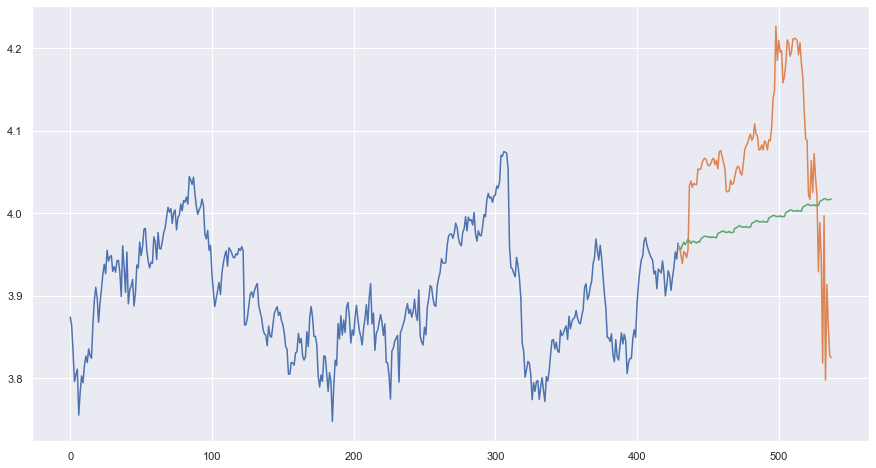

In [29]:
# plot
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid['close'])

# plot
rcParams['figure.figsize'] = 15,8
plt.plot(forecast['Prediction'])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Auto_Arima_lv2.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Auto ARIMA' is not an appropriate predictive technique for this data set.

### 4.5 ARIMA    

In [30]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [31]:
# set sub dataset 
training = train['close']
validation = valid['close']

model_autoARIMA = auto_arima(training, 
                             start_p=0, 
                             start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=3, 
                             max_q=3,          # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-2160.392, BIC=-2152.269, Time=0.129 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-2163.407, BIC=-2151.223, Time=0.172 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-2163.193, BIC=-2151.008, Time=0.205 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-2162.342, BIC=-2158.281, Time=0.041 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-2161.432, BIC=-2145.186, Time=0.151 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-2161.389, BIC=-2145.143, Time=0.182 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-2159.475, BIC=-2139.167, Time=0.598 seconds
Total fit time: 1.494 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  430
Model:               SARIMAX(1, 1, 0)   Log Likelihood              

So the Auto ARIMA model provided the value of p,d, and q as SARIMAX(1, 1, 0) respectively. Before moving forward, let’s review the residual plots from auto ARIMA.

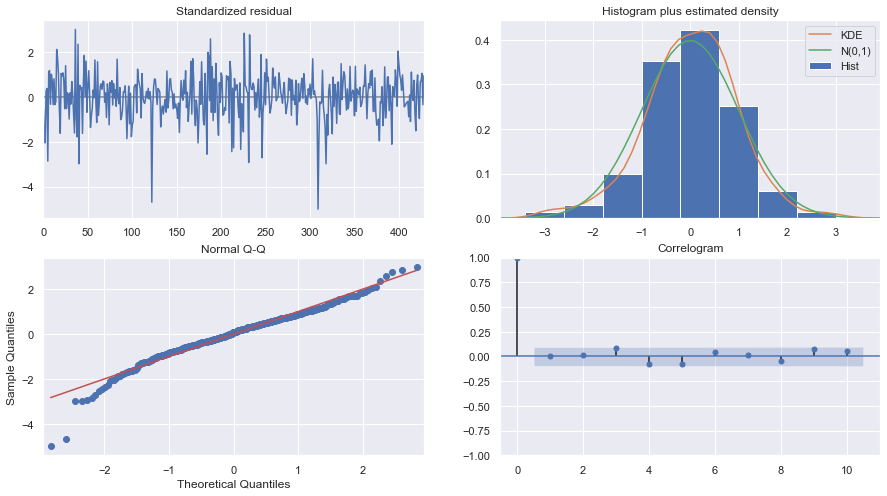

In [32]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Arima_Auto_lv2.jpg')

So how to interpret the plot diagnostics?

- **Top left**: The residual errors seem to fluctuate around a mean of zero and and do not have a uniform variance.
- **Top Right**: The density plot suggest normal distribution with mean zero.
- **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. As can be easily seen on the left of the graph
- **Bottom Right**: The `Correlogram`, aka, `ACF` plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices. Next, create an ARIMA model with provided optimal parameters p, d and q.

#### Obtained by the algorithm

In [33]:
modelsegA = ARIMA(np.asarray(training), order=(1, 1, 0))  
fittedsegA = modelsegA.fit(disp=-1)  
print(fittedsegA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  429
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1084.703
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 28 Mar 2020   AIC                          -2163.407
Time:                        00:45:58   BIC                          -2151.223
Sample:                             1   HQIC                         -2158.595
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.246      0.806      -0.001       0.002
ar.L1.D.y     -0.1078      0.048     -2.246      0.025      -0.202      -0.014
                                    Roots           

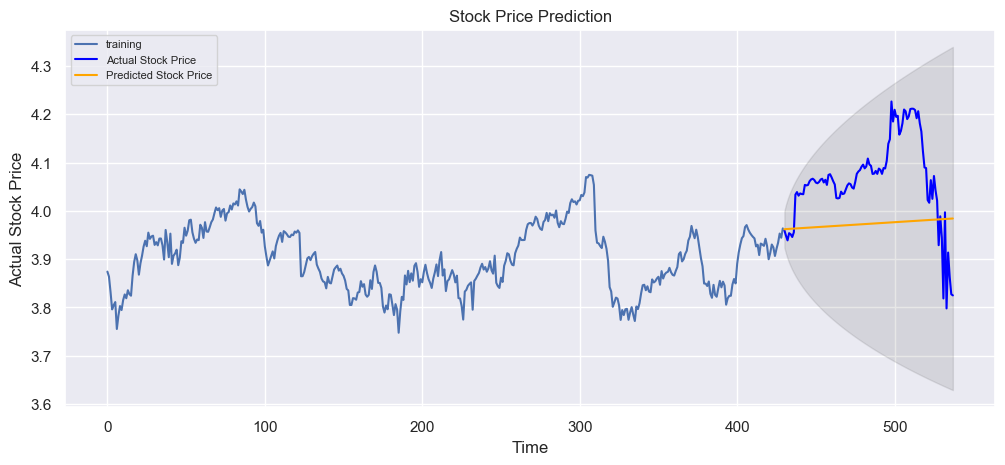

In [34]:
# Forecast
fcA, se, conf = fittedsegA.forecast(valid_rows, alpha=0.05)  # 95% confidence

fc_seriesA = pd.Series(fcA, index=validation.index)

lower_seriesA = pd.Series(conf[:, 0], index=validation.index)
upper_seriesA = pd.Series(conf[:, 1], index=validation.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(validation, color = 'blue', label='Actual Stock Price')
plt.plot(fc_seriesA, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_seriesA.index, lower_seriesA, upper_seriesA, color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
# report performance
mse = mean_squared_error(validation, fcA)
print('MSE: '+str(mse))

mae = mean_absolute_error(validation, fcA)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(validation, fcA))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(fcA - validation)/np.abs(validation))
print('MAPE: '+str(mape))

MSE: 0.016242141052924177
MAE: 0.11139553744846974
RMSE: 0.1274446587853888
MAPE: 0.027200428481572187


#### Suggested by the referred article [Here](https://towardsdatascience.com/stock-market-forecasting-using-time-series-c3d21f2dd37f)

In [36]:
modelsegB = ARIMA(np.asarray(training), order=(3, 1, 2))  
fittedsegB = modelsegB.fit(disp=-1)  
print(fittedsegB.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  429
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1090.587
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 28 Mar 2020   AIC                          -2167.173
Time:                        00:46:22   BIC                          -2138.743
Sample:                             1   HQIC                         -2155.946
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.212      0.832      -0.002       0.002
ar.L1.D.y     -0.5254      0.208     -2.531      0.011      -0.932      -0.118
ar.L2.D.y     -0.7455      0.137     -5.445      0.0

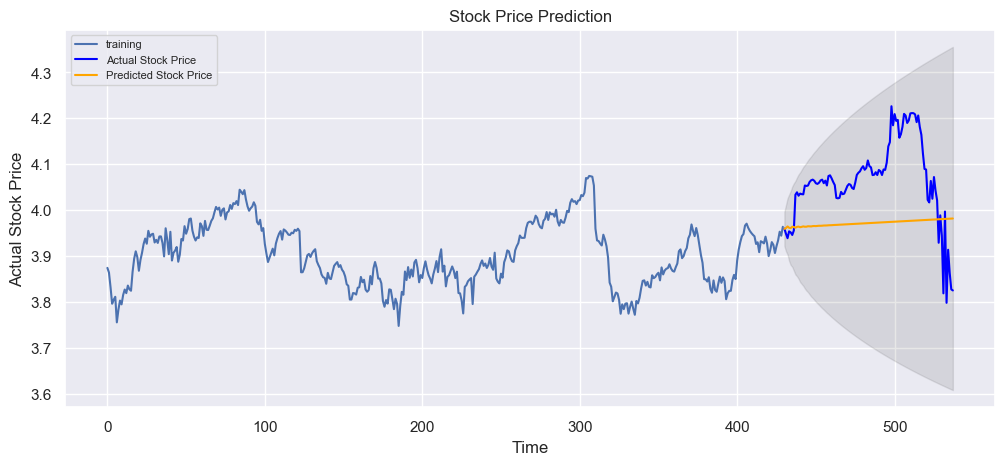

In [37]:
# Forecast
fcB, se, conf = fittedsegB.forecast(valid_rows, alpha=0.05)  # 95% confidence

fc_seriesB = pd.Series(fcB, index=validation.index)

lower_seriesB = pd.Series(conf[:, 0], index=validation.index)
upper_seriesB = pd.Series(conf[:, 1], index=validation.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(validation, color = 'blue', label='Actual Stock Price')
plt.plot(fc_seriesB, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_seriesB.index, lower_seriesB, upper_seriesB, color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [38]:
# report performance
mse = mean_squared_error(validation, fcB)
print('MSE: '+str(mse))

mae = mean_absolute_error(validation, fcB)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(validation, fcB))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(fcB - validation)/np.abs(validation))
print('MAPE: '+str(mape))

MSE: 0.016504918362621804
MAE: 0.11238714181409408
RMSE: 0.12847146906072882
MAPE: 0.027439475086555868


#### Suggested by Time Series Decomposition [Here](https://github.com/erojaso/Forecasting-Stock-Prices/blob/master/02_stock_price_forecast_time_series_decomposition.ipynb)

In [39]:
modelsegC = ARIMA(np.asarray(training), order=(3,1,3))  
fittedsegC = modelsegC.fit(disp=-1)  
print(fittedsegC.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  429
Model:                 ARIMA(3, 1, 3)   Log Likelihood                1091.100
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 28 Mar 2020   AIC                          -2166.200
Time:                        00:46:34   BIC                          -2133.708
Sample:                             1   HQIC                         -2153.369
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.229      0.819      -0.001       0.002
ar.L1.D.y     -1.1337      0.492     -2.304      0.021      -2.098      -0.169
ar.L2.D.y     -1.2437      0.361     -3.442      0.0

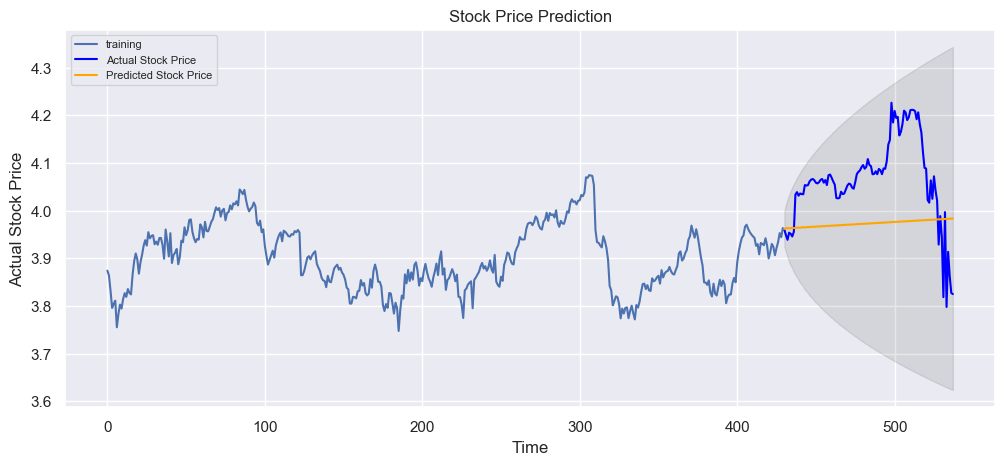

In [40]:
# Forecast
fcC, se, conf = fittedsegC.forecast(valid_rows, alpha=0.05)  # 95% confidence

fc_seriesC = pd.Series(fcC, index=validation.index)

lower_seriesC = pd.Series(conf[:, 0], index=validation.index)
upper_seriesC = pd.Series(conf[:, 1], index=validation.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(validation, color = 'blue', label='Actual Stock Price')
plt.plot(fc_seriesC, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_seriesC.index, lower_seriesC, upper_seriesC, color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
# report performance
mse = mean_squared_error(validation, fcC)
print('MSE: '+str(mse))

mae = mean_absolute_error(validation, fcC)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(validation, fcC))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(fcC - validation)/np.abs(validation))
print('MAPE: '+str(mape))

MSE: 0.016247498339282494
MAE: 0.11139546811725472
RMSE: 0.12746567514151602
MAPE: 0.027199654386808114


As seen in the indicators, none of the models did well. Looking at the individual metrics for each of the examples, these results are evident.

### 4.6 Prophet

In [42]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# preparing data
new_data.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [47]:
# fit the model
model = Prophet(yearly_seasonality=True)
model.fit(train)

# predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)
forecast_valid = forecast['yhat'][train_rows:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
# report performance
mse = mean_squared_error(valid['y'], forecast_valid)
print('MSE: '+str(mse))

mae = mean_absolute_error(valid['y'], forecast_valid)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid['y'], forecast_valid))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(forecast_valid - valid['y'])/np.abs(valid['y']))
print('MAPE: '+str(mape))

MSE: 0.01570181840642733
MAE: 0.07687548515690351
RMSE: 0.12530689688292232
MAPE: 0.019244789017444773


The MAPE indicator around 11.60% implies that the model has an accuracy close to 88.45% to predict the observations of the data set. The RMSE 7.83% indicates that it is correct and that we are approaching a better prediction model.

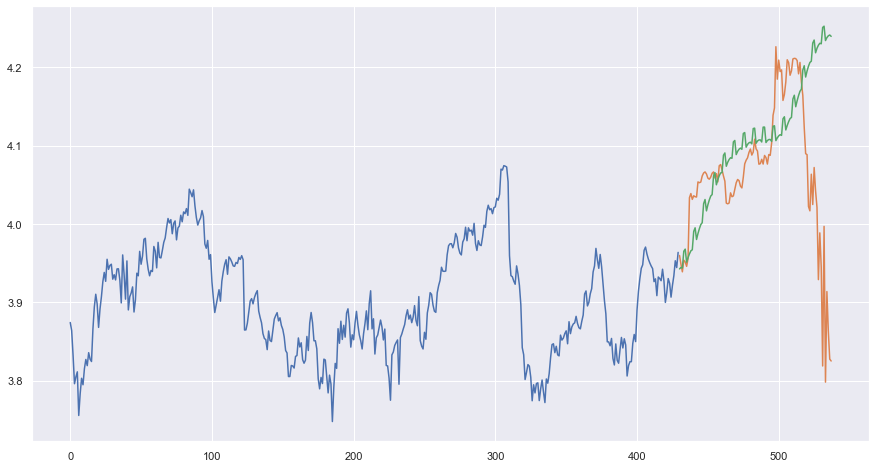

In [49]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

rcParams['figure.figsize'] = 15,8
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Prophet_lv2.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Prophet' is not an appropriate predictive technique for this data set.

### 4.7 Long Short Term Memory (LSTM)

In [50]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]
   
# setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)   

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 1)

 Shape of validation set:
(108, 1)


In [51]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_data)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [52]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 18s - loss: 0.0085


In [53]:
# predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [54]:
# report performance
mse = mean_squared_error(valid, closing_price)
print('MSE: '+str(mse))

mae = mean_absolute_error(valid, closing_price)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid, closing_price))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(closing_price - valid)/np.abs(valid))
print('MAPE: '+str(mape))

MSE: 0.0014572408188889283
MAE: 0.025951438883073934
RMSE: 0.03817382373942815
MAPE: close    0.006416
dtype: float64


The MAPE indicator around 3.33% implies that the model has an accuracy close to 96.66% to predict the observations of the data set. The RMSE 2.52% indicates that it is correct and that we are approaching a better prediction model.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

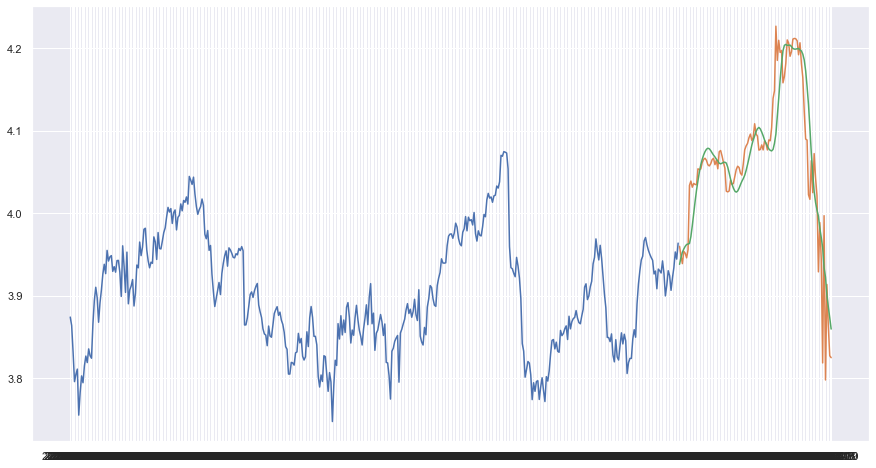

In [55]:
#for plotting
train = new_data[:train_rows]
valid = new_data[train_rows:]

valid['Predictions'] = closing_price

rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_LSTM_lv2.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Long Short Term Memory (LSTM)' is an appropriate predictive technique for this data set.

### 4.8 LSTM Optimized [Source Here](https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a) - [Code](https://github.com/NGYB/Stocks/tree/master/StockPricePrediction)

In [56]:
#### Input params ##################
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning

lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
tf.random.set_seed(model_seed) # set_random_seed(model_seed)

In [57]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [58]:
def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [59]:
def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

In [73]:
def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

#### 4.8.1 Feature Engineering

In [60]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# create features
add_datepart(new_data, 'date', drop=False)

# remove atribute 'Elapsed', axis=1 means colummn
new_data.drop('Elapsed', axis=1, inplace=True)
    
# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 14)

 Shape of validation set:
(108, 14)


In [61]:
new_data.info()
print('\n')
new_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 14 columns):
date                538 non-null datetime64[ns]
close               538 non-null object
Year                538 non-null int64
Month               538 non-null int64
Week                538 non-null int64
Day                 538 non-null int64
Dayofweek           538 non-null int64
Dayofyear           538 non-null int64
Is_month_end        538 non-null bool
Is_month_start      538 non-null bool
Is_quarter_end      538 non-null bool
Is_quarter_start    538 non-null bool
Is_year_end         538 non-null bool
Is_year_start       538 non-null bool
dtypes: bool(6), datetime64[ns](1), int64(6), object(1)
memory usage: 36.9+ KB




date    close  Year  Month  Week  Day  Dayofweek  Dayofyear  \
0 2018-01-31  3.87411  2018      1     5   31          2         31   
1 2018-02-01  3.86388  2018      2     5    1          3         32   
2 2018-02-02   3.8319  2018      2     5    2          4         33   
3 2018-02-05  3.79594  2018      2     6    5          0         36   
4 2018-02-06  3.80466  2018      2     6    6          1         37   

   Is_month_end  Is_month_start  Is_quarter_end  Is_quarter_start  \
0          True           False           False             False   
1         False            True           False             False   
2         False           False           False             False   
3         False           False           False             False   
4         False           False           False             False   

   Is_year_end  Is_year_start  
0        False          False  
1        False          False  
2        False          False  
3        False          False  
4        False          False

#### 4.8.2 Training, Validation, Test split

In [62]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(new_data))
num_test = int(test_size*len(new_data))
num_train = len(new_data) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = new_data[:num_train][['date', 'close']]
cv = new_data[num_train:num_train+num_cv][['date', 'close']]
train_cv = new_data[:num_train+num_cv][['date', 'close']]
test = new_data[num_train+num_cv:][['date', 'close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 324
num_cv = 107
num_test = 107
train.shape = (324, 2)
cv.shape = (107, 2)
train_cv.shape = (431, 2)
test.shape = (107, 2)


#### 4.8.3 Feature Scaling

In [63]:
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

scaler.mean_ = [3.909962]
scaler.var_ = [0.004805]
x_train_scaled.shape = (315, 9, 1)
y_train_scaled.shape = (315, 1)


In [64]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (107, 9, 1)
y_cv.shape = (107, 1)
len(mu_cv_list) = 107
len(std_cv_list) = 107


In [65]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(['close']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [3.901934]
scaler_final.var_ = [0.004559]
x_test_scaled.shape = (0,)
y_test.shape = (0,)
len(mu_test_list) = 0
len(std_test_list) = 0


#### 4.8.4 Create and fit the LSTM network

In [90]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/1
 - 3s - loss: 0.2252


In [92]:
# Print model summary
model.summary()

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_241 (LSTM)              (None, 3, 50)             10400     
_________________________________________________________________
dropout_239 (Dropout)        (None, 3, 50)             0         
_________________________________________________________________
lstm_242 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_240 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


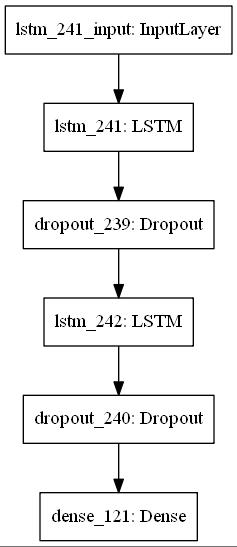

In [93]:
# Plot model and save to file
plot_model(model, to_file='.\\images\\Close_Stock_Price_LSTM_Opt_Model_lv2.jpg')

In [264]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [94]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (107, 1)
RMSE = 0.021
MAPE = 0.431%


In [95]:
# report performance
mse = mean_squared_error(y_cv, est)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_cv, est)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_cv, est))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(est - y_cv)/np.abs(y_cv))
print('MAPE: '+str(mape))

MSE: 0.0004523418625465711
MAE: 0.016745234340580777
RMSE: 0.021268330036619498
MAPE: 0.00431412301127735


The MAPE indicator around 2.25% implies that the model has an accuracy close to 97.75% to predict the observations of the data set. The RMSE 1.45% indicates how close we are and we have the best prediction model.

Text(0, 0.5, 'USD')

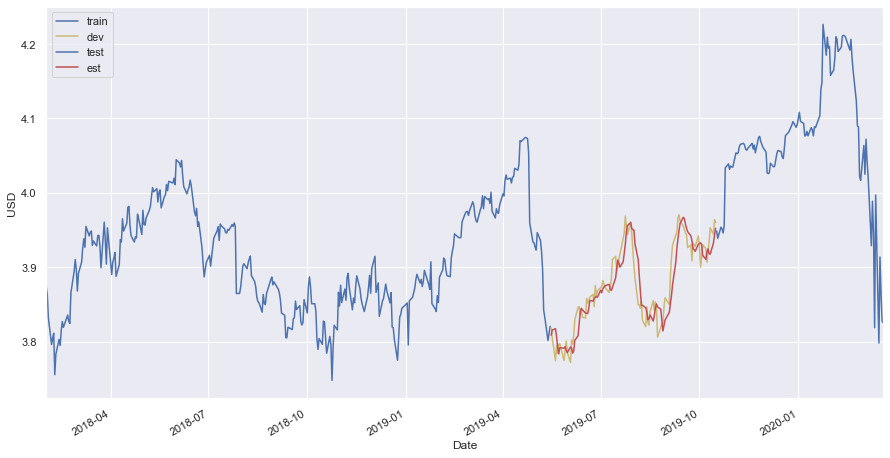

In [96]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='b-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")

#### 4.8.4 Tuning N (no. of days to use as features)

In [97]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 13.36999864578247


N      rmse  mape_pct
0    3  0.022554  0.456220
1    4  0.023375  0.465440
2    5  0.027089  0.538261
3    6  0.027010  0.535800
4    7  0.028894  0.569804
5    8  0.027008  0.533429
6    9  0.029168  0.577783
7   10  0.027878  0.552396
8   11  0.028435  0.563456
9   12  0.027791  0.549318
10  13  0.027727  0.544503
11  14  0.028230  0.556504
12  15  0.028164  0.554898
13  16  0.028784  0.568587
14  17  0.026589  0.527680
15  18  0.028038  0.556363
16  19  0.026508  0.522288
17  20  0.028886  0.572449
18  21  0.027116  0.541609
19  22  0.028654  0.562369
20  23  0.028553  0.571784
21  24  0.030224  0.603551
22  25  0.028759  0.570486
23  26  0.029434  0.578562
24  27  0.031933  0.644505
25  28  0.028568  0.568475
26  29  0.029725  0.588050
27  30  0.029409  0.580552
28  31  0.029743  0.585307
29  32  0.028545  0.589959
30  33  0.030926  0.629476
31  34  0.030692  0.625355
32  35  0.032094  0.641786
33  36  0.033155  0.668049
34  37  0.029566  0.605841
35  38  0.034151  0.665658
36  39  0.029622  0.589670
37  40  0.033930  0.679086
38  41  0.034362  0.682731
39  42  0.032418  0.638829
40  43  0.030794  0.619760
41  44  0.031799  0.639220
42  45  0.031553  0.643366
43  46  0.031985  0.629167
44  47  0.033833  0.673236
45  48  0.031677  0.629719
46  49  0.033476  0.671387
47  50  0.031607  0.632897
48  51  0.032804  0.635150
49  52  0.029825  0.604681
50  53  0.033219  0.672453
51  54  0.032534  0.641646
52  55  0.033554  0.687994
53  56  0.030419  0.611247
54  57  0.034543  0.674663
55  58  0.030553  0.615940
56  59  0.032656  0.645429

Text(0, 0.5, 'RMSE/MAPE(%)')

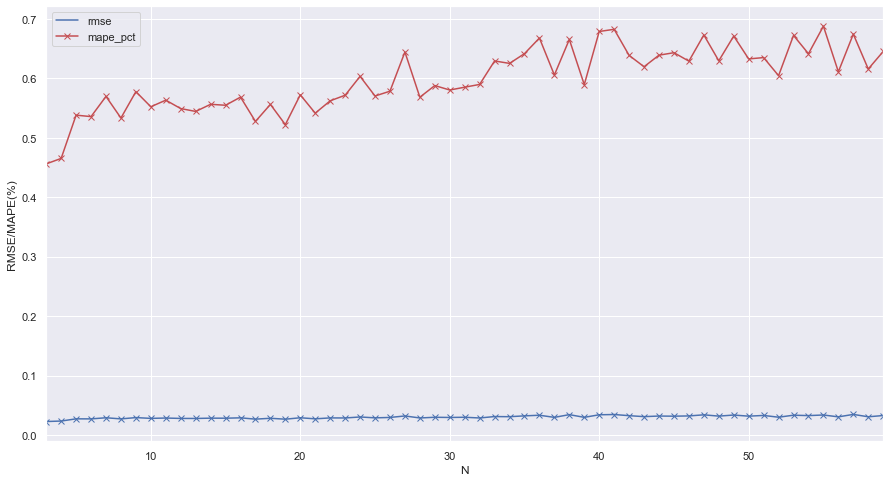

In [98]:
# Plot RMSE 
rcParams['figure.figsize'] = 15, 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [99]:
# report performance
mse = mean_squared_error(y_cv, est)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_cv, est)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_cv, est))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(est - y_cv)/np.abs(y_cv))
print('MAPE: '+str(mape))

# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]

MSE: 0.0004523418625465711
MAE: 0.016745234340580777
RMSE: 0.021268330036619498
MAPE: 0.00431412301127735


In [100]:
temp

N      rmse  mape_pct
0  3  0.022554   0.45622

In [101]:
N_opt

3

In [102]:
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 3.9939075469970704


N  batch_size      rmse  mape_pct
0    1           8  0.021967  0.444596
1    1          16  0.019937  0.406588
2    1          32  0.019655  0.401515
3    1          64  0.019523  0.398820
4    1         128  0.019432  0.397402
5   10           8  0.020997  0.426836
6   10          16  0.021074  0.428598
7   10          32  0.021837  0.442923
8   10          64  0.021952  0.444405
9   10         128  0.021042  0.427304
10  20           8  0.016985  0.355441
11  20          16  0.020023  0.408520
12  20          32  0.020980  0.426457
13  20          64  0.021662  0.439514
14  20         128  0.021768  0.441252
15  30           8  0.016304  0.345098
16  30          16  0.018111  0.374698
17  30          32  0.020269  0.413217
18  30          64  0.021570  0.437580
19  30         128  0.021840  0.442802
20  40           8  0.016196  0.343909
21  40          16  0.016406  0.346890
22  40          32  0.020111  0.409960
23  40          64  0.021306  0.432791
24  40         128  0.021732  0.440803
25  50           8  0.016112  0.342152
26  50          16  0.016229  0.344559
27  50          32  0.018943  0.389072
28  50          64  0.020839  0.424053
29  50         128  0.021512  0.436837

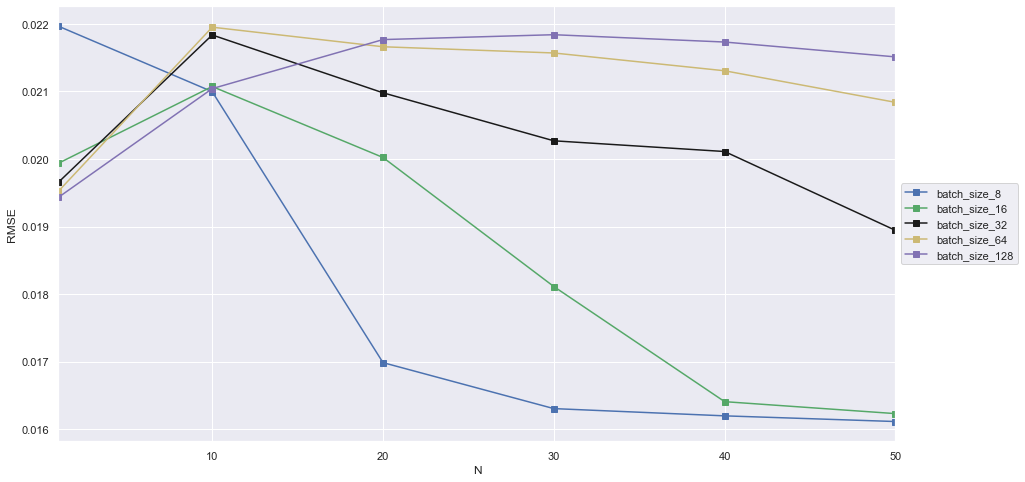

In [103]:
rcParams['figure.figsize'] = 15, 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [104]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 0.016
min MAPE = 0.342%
optimum N = 50
optimum batch_size = 8


#### 4.8.5 Tuning model - LSTM units and dropout prob

In [105]:
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 8.258260722955068


N  dropout_prob      rmse  mape_pct
0    10           0.5  0.020171  0.411325
1    10           0.6  0.020060  0.409195
2    10           0.7  0.020611  0.419699
3    10           0.8  0.021164  0.430258
4    10           0.9  0.020628  0.419696
5    10           1.0  0.016862  0.353923
6    50           0.5  0.016548  0.347866
7    50           0.6  0.016789  0.351179
8    50           0.7  0.017498  0.363761
9    50           0.8  0.019005  0.389705
10   50           0.9  0.020512  0.417689
11   50           1.0  0.016242  0.344778
12   64           0.5  0.016605  0.349674
13   64           0.6  0.016592  0.348188
14   64           0.7  0.016981  0.354094
15   64           0.8  0.018353  0.378214
16   64           0.9  0.020328  0.414203
17   64           1.0  0.016255  0.345164
18  128           0.5  0.016495  0.347237
19  128           0.6  0.016502  0.346471
20  128           0.7  0.016958  0.354016
21  128           0.8  0.017459  0.362878
22  128           0.9  0.019973  0.407314
23  128           1.0  0.016040  0.340430

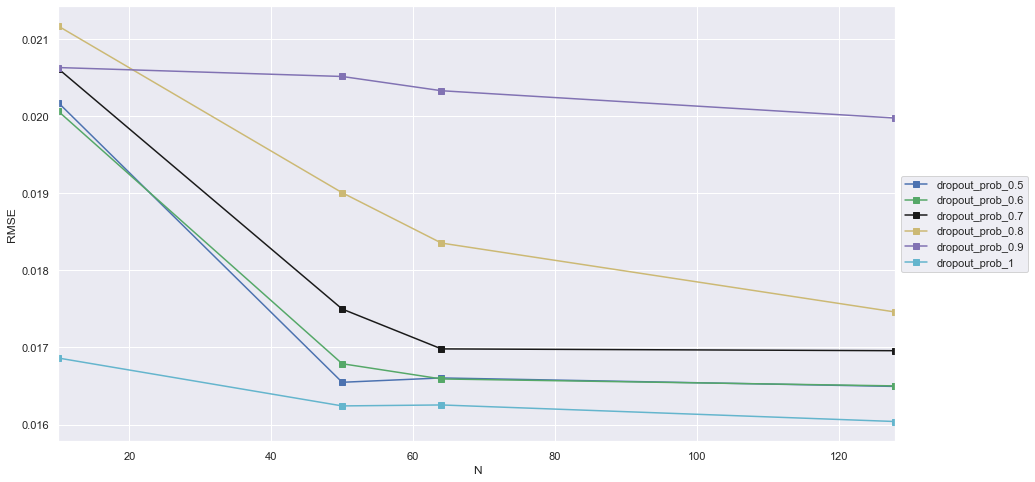

In [106]:
rcParams['figure.figsize'] = 15, 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [107]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 0.016
min MAPE = 0.340%
optimum N = 128
optimum dropout_prob = 1.0


#### 4.8.5 Tuning model - optimizer

In [108]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 3.3421446720759076


optimizer      rmse  mape_pct
0      adam  0.016232  0.344787
1       sgd  0.020448  0.416556
2   rmsprop  0.016279  0.345793
3   adagrad  0.016035  0.340895
4  adadelta  0.015762  0.335352
5    adamax  0.015940  0.338626
6     nadam  0.016038  0.340155

Text(0, 0.5, 'RMSE/MAPE(%)')

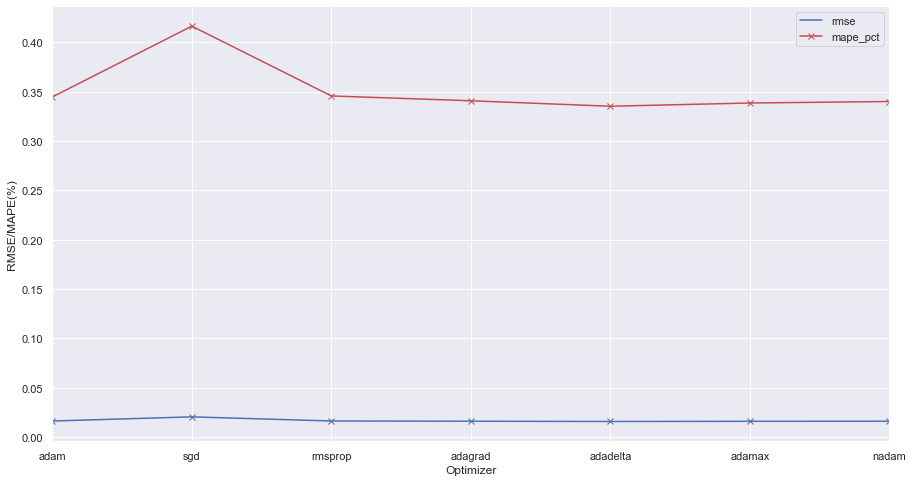

In [109]:
# Plot RMSE 
rcParams['figure.figsize'] = 15, 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [110]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 0.016
min MAPE = 0.335%
optimum optimizer = adadelta


In [111]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

param   original after_tuning
0             N          9            3
1    lstm_units         50          128
2  dropout_prob          1            1
3     optimizer       adam     adadelta
4        epochs          1           50
5    batch_size          1            8
6          rmse  0.0212683    0.0157622
7      mape_pct   0.431412     0.335352

#### 4.8.6 Applying the Model

In [112]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(new_data['close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.036
MAPE on test set = 0.490%


Text(0, 0.5, 'USD')

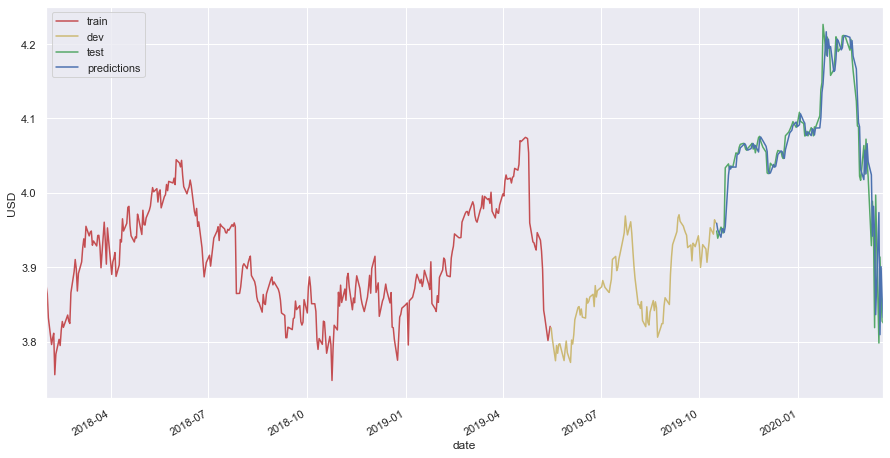

In [113]:
rcParams['figure.figsize'] = 15, 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': new_data[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='close', style='r-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='b-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Test Dataset Overlapping')

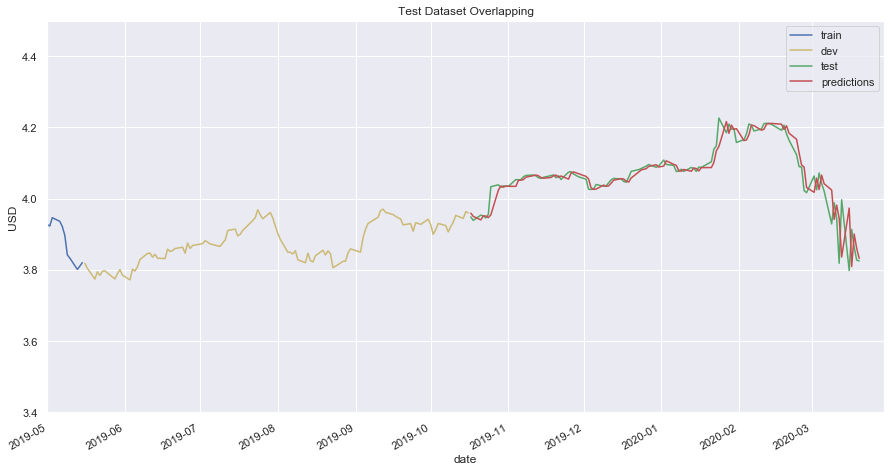

In [122]:
# set start and end date range
start_date = dt.datetime(2019, 5, 1)
end_date = dt.datetime(2020, 3, 30)

rcParams['figure.figsize'] = 15, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([start_date, end_date])
ax.set_ylim([3.4, 4.5])
ax.set_title("Test Dataset Overlapping")

(3.4, 4.5)

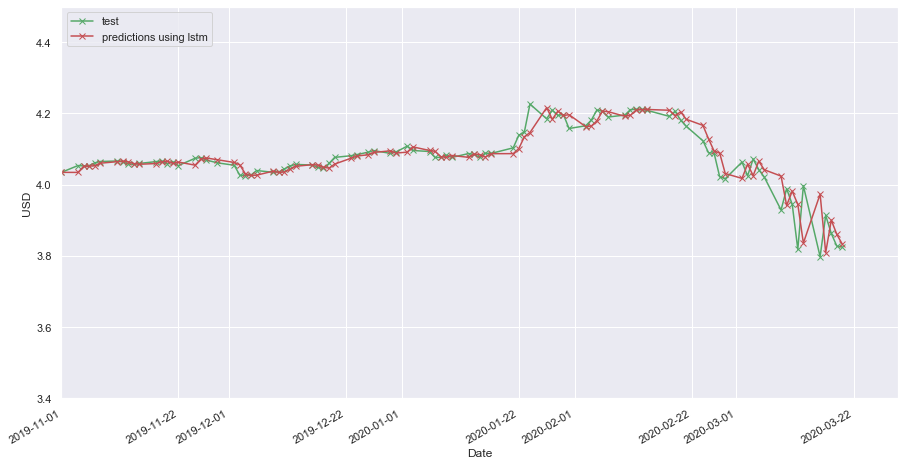

In [123]:
# set start and end date range
start_date = dt.datetime(2019, 11, 1)
end_date = dt.datetime(2020, 3, 30)

rcParams['figure.figsize'] = 15, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("Date")
ax.set_ylabel("USD")
ax.set_xlim([start_date, end_date])
ax.set_ylim([3.4, 4.5])

In [124]:
# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.036
MAPE on test set = 0.490%


The MAPE indicator around 1.95% implies that the model has an accuracy close to 98.05% to predict the observations of the data set. The RMSE 1.87% indicates that it is best approach prediction model.